# Step 3: Get a time series and clean outliers

- From the previous step, we have a nice function that estimates crossing and angle for every cuscuta
- Put that into a loop for a whole repetition
- Put crossing and angle information as a time series for each individual plant
- More often than not, there are outliers that have to be removed and kinks smoothed
- Still working on a way to fully automate this part

In [300]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tf

from scipy import spatial, ndimage, signal, interpolate

import os
import json
import pandas as pd

from sklearn import linear_model, cluster
import utils
from importlib import reload

In [163]:
colors = ['#aa4499', '#117733', '#88ccee', '#ddcc77', '#44aa99']
markers = ['s','D','o','^','v','<','>','*']
buffx = 0
buffX = 1475
buffy = 200
buffz = 50
nsamples = 5

isrc = '../raw/'
rsrc = '../reference/'
ssrc = '../proc/skel/'
time = '4pm'
rep = 7

meta = pd.read_csv(rsrc + 'reference_positions_{}_rep{}.csv'.format(time, rep))
meta = meta.set_index('numidx')
meta.head()

,peaks_0,peaks_1,peaks_2,peaks_3,peaks_4,tapes_0,tapes_1,tapes_2,tapes_3,tapes_4,coef0_0,coef0_1,coef0_2,coef0_3,coef0_4,coef1_0,coef1_1,coef1_2,coef1_3,coef1_4
numidx,,,,,,,,,,,,,,,,,,,,
1,617,1307,2081,2945,3787,903,992,995,1194,1395,224.909,228.658,190.235,183.072,189.759,-0.017661,-0.021867,0.001748,0.014864,0.009036
2,597,1291,2069,2931,3769,893,980,983,1181,1412,227.745,200.906,186.711,181.974,192.363,-0.017171,0.005466,0.004167,0.015038,0.008791
3,573,1296,2061,2927,3762,903,991,993,1221,1447,236.140,188.049,187.639,183.790,190.927,-0.007194,0.008313,0.003852,0.011888,0.011083
4,583,1296,2064,2930,3766,890,978,979,1174,1402,232.565,181.112,185.558,180.871,187.369,-0.011769,0.015637,0.003632,0.012464,0.010194
5,604,1297,2065,2925,3761,891,976,979,1176,1428,218.414,201.373,184.803,182.785,189.889,-0.017212,-0.003465,0.003809,0.014073,0.009635


# Using the functions from the previous notebook

- Store info in lists of dictionaries.
- One dictionary for positions; another for angles

In [3]:
reload(utils)
pdicts = [dict() for i in range(nsamples)]
adicts = [dict() for i in range(nsamples)]

for idx in meta.index.values:
    n, lines, xvals, plants = utils.get_img_metadata(meta, idx, nsamples, buffx, buffX, buffy, buffz)
    for pidx in range(nsamples):
        
        xlen, line, b = utils.get_plant_metadata(pidx, plants, xvals, lines, n)
        
        filename = ssrc + '{}_rep{}/plant_{:02d}/{}_rep{}_p{:02d}_{:04d}.csv'.format(time, rep, pidx, time, rep, pidx, idx)
        skeleton = np.loadtxt(filename, dtype=int, delimiter=',')
    
        dist = np.abs(skeleton[1]*n[pidx, 0] + skeleton[0]*n[pidx, 1] - b)
        dmask = dist < 15
        mmask = dist < 25
        if np.sum(dmask) > 5:
            clusts, uq, seeds = utils.get_cluster_seeds(skeleton, dist, dmask)
            nclusts = utils.expand_cluster_labels(skeleton, clusts, dmask, mmask)
            coefs, angle = utils.get_coil_metadata(skeleton, mmask, nclusts, uq, dist, n[pidx])

            pdicts[pidx][idx] = seeds[uq]
            adicts[pidx][idx] = angle

warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning


# Clean outliers

- Convert the dictionary into a large `nx2` array
- Perform DBSCAN to define large clusters
    - Position information is much more stable than angle one
    - Thus, we're going to label the `pos` data and simply repeat those labels for `ang`
- Ostensibly, a large cluster should correspond to a coil
- Play around with the DBSCAN hyperparameters until the clusters look ok

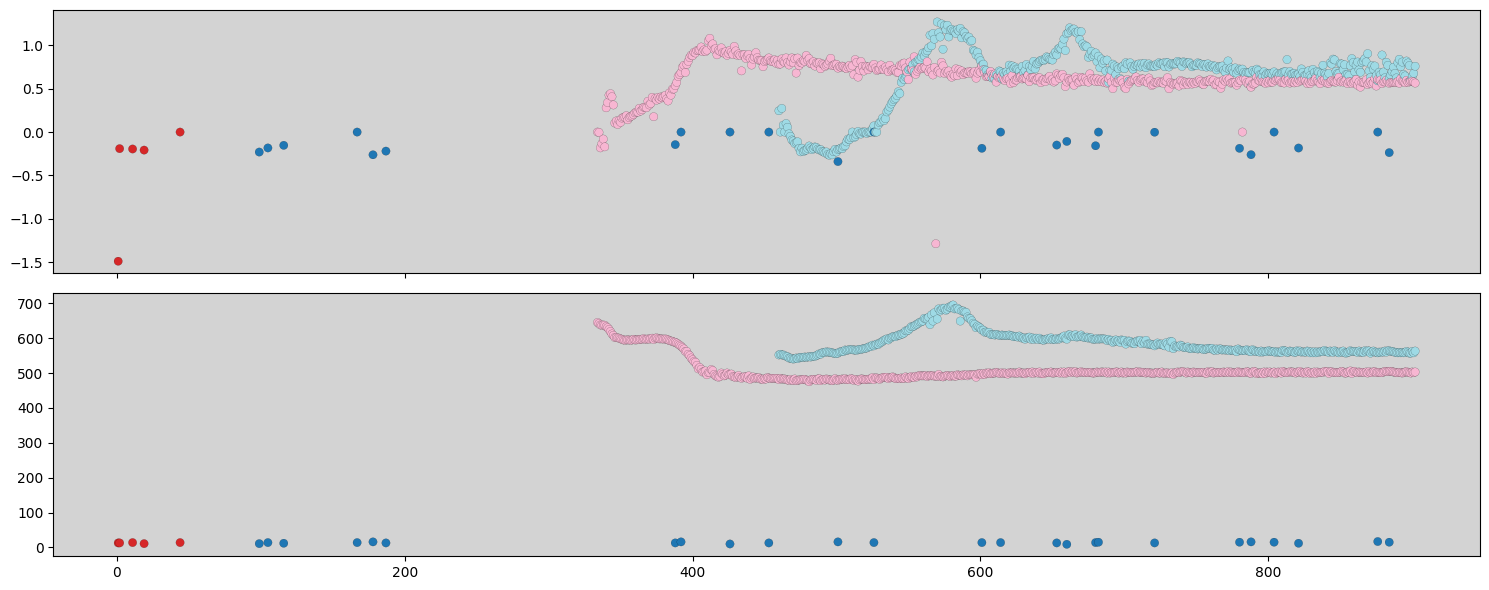

In [504]:
pidx = 0
nums = np.zeros(910, dtype=int)
for key in pdicts[pidx]:
    nums[key] = len(pdicts[pidx][key])

tapes = meta.loc[pdicts[pidx].keys(), 'tapes_{}'.format(pidx)]
pos = np.zeros((np.sum(nums),2), dtype=int)
ang = np.zeros(pos.shape)
i = 0
for key in pdicts[pidx]:
    for j in range(len(pdicts[pidx][key])):
        pos[i] = [ key, tapes.loc[key] - pdicts[pidx][key][j,0] ]
        #pos[i] = [ key, np.min(tapes) - pdicts[pidx][key][j,0] ]
        ang[i] = [ key, adicts[pidx][key][j] ]
        i += 1

hdb = cluster.DBSCAN(min_samples=5, eps = 30).fit_predict(pos)
#for i in [-1,2,3,4]:
#    hdb[hdb == i] = 5
uq = np.unique(hdb)

fig, ax = plt.subplots(2,1,figsize=(15,6), sharex=True)
ax = np.atleast_1d(ax).ravel()

ax[0].scatter(ang[:,0], ang[:,1], c=hdb, cmap='tab20', edgecolor='k', linewidths=0.1)
ax[1].scatter(pos[:,0], pos[:,1], c=hdb, cmap='tab20', edgecolor='k', linewidths=0.1)

for i in range(len(ax)):
    ax[i].set_facecolor('lightgray')
fig.tight_layout();

In [505]:
hist , _  = np.histogram(hdb, bins=np.hstack((uq, uq[-1]+2)) )
coil_mask = hist/len(pos) > 0.25
print(uq, hist, hist/len(pos), coil_mask, sep='\n')
uq = uq[coil_mask]
medians = np.zeros(len(uq))
for i in range(len(uq)):
    medians[i] = np.median(pos[hdb == uq[i], 1])
uq = uq[np.argsort(medians)]
bookends = np.zeros((len(uq), 2), dtype=int)
for i in range(len(uq)):
    bookends[i] = pos[hdb == uq[i], 0][np.array([0,-1])]
print('Start points:\n',bookends)
uq

[-1  0  1  2]
[ 25   5 569 442]
[0.02401537 0.00480307 0.54658982 0.42459174]
[False False  True  True]
Start points:
 [[334 902]
 [460 902]]


array([1, 2])

In [506]:
if False:
    i = 0
    foo = np.nonzero(hdb == uq[i])[0]
    bar = np.nonzero(ang[hdb==uq[i],1] < 0)[0]
    hdb[foo[bar]] += 10

    i = 1
    foo = np.nonzero(hdb == uq[i])[0]
    bar = np.nonzero(ang[hdb==uq[i],1] > -0.25)[0]
    hdb[foo[bar][35:]] += 10

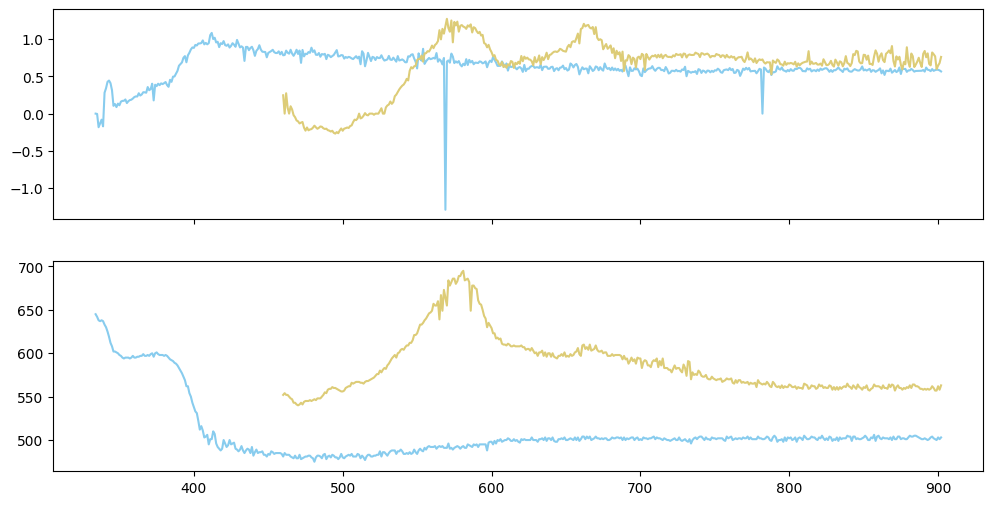

In [507]:
colors = ['#aa4499', '#117733', '#88ccee', '#ddcc77', '#44aa99']

fig, ax = plt.subplots(2,1,figsize=(12,6), sharex=True)

for i in range(len(uq)):
    ax[0].plot(ang[hdb==uq[i],0], ang[hdb==uq[i],1], color=colors[i+2])
    ax[1].plot(pos[hdb==uq[i],0], pos[hdb==uq[i],1], color=colors[i+2])

# Outlier removal and smoothening

- Create separate arrays for each coil
- Interpolate missing data (missing timepoints) with a simple linear interpolator
- Perform a median filter of size `size` to remove outliers
- Finish with a SavGol filter to smooth the final time series
- Save the time series into a single JSON
- We only save the smoothened values

In [508]:
def smooth_signal(original, hdb, uq, bookends, dtype=int, wlen=15, size=11, mode='nearest'):
    mpos = [ np.zeros((bookends[i,1]+1 ,2),dtype=dtype) for i in range(len(uq))]
    for i in range(len(uq)):
        foo = original[hdb == uq[i]]
        mpos[i][:,0] = np.arange(bookends[i,1]+1)
        mpos[i][foo[:,0].astype(int) , 1] = foo[:,1]
        mpos[i] = mpos[i][bookends[i,0]:]

        x = mpos[i][np.nonzero(mpos[i][:,1] == 0)[0], 0]
        xp = mpos[i][np.nonzero(mpos[i][:,1] != 0)[0], 0]
        fp = mpos[i][np.nonzero(mpos[i][:,1] != 0)[0], 1]

        mpos[i][np.nonzero(mpos[i][:,1] == 0)[0], 1] = np.interp(x,xp,fp)
        
        mpos[i][:,1] = ndimage.median_filter(mpos[i][:,1], size=size, mode=mode)
        mpos[i][:,1] = signal.savgol_filter(mpos[i][:,1], window_length=wlen, polyorder=2, deriv=0, delta=1, mode=mode)    
    
    return mpos

In [509]:
wlen = 15
size = 9
mpos = smooth_signal(pos, hdb, uq, bookends, int, wlen, size=size, mode='nearest')
mang = smooth_signal(ang, hdb, uq, bookends, float, wlen, size=size, mode='nearest')

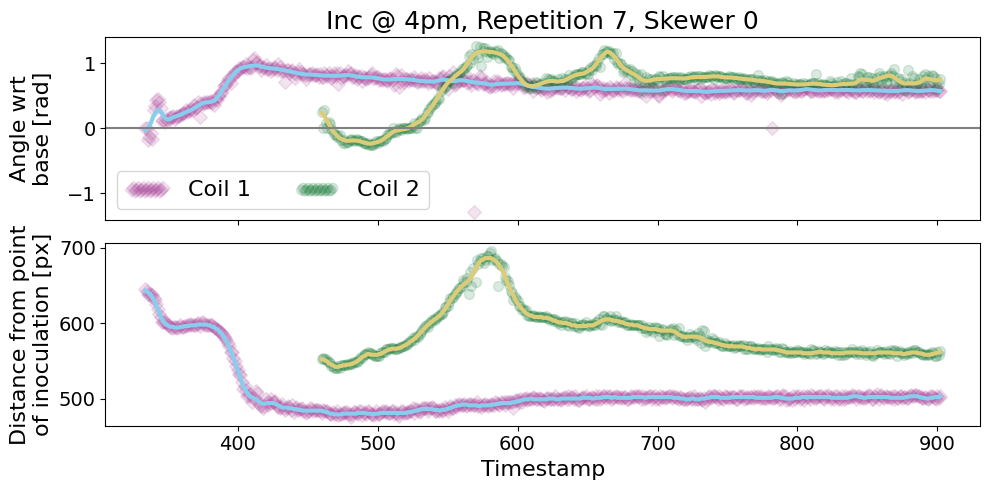

In [510]:
fs = 16
fig, ax = plt.subplots(2,1,figsize=(10,5), sharex=True)

for i in range(len(uq)):
    label = 'Coil {}'.format(i+1)
    ax[0].scatter(ang[hdb==uq[i],0], ang[hdb==uq[i],1], s=50, color=colors[i], zorder=1, alpha=0.15, marker=markers[i+1], label=label)
    ax[1].scatter(pos[hdb==uq[i],0], pos[hdb==uq[i],1], s=50, color=colors[i], zorder=1, alpha=0.15, marker=markers[i+1])
    
    ax[0].plot(mang[i][:,0], mang[i][:,1], lw=3, color=colors[i+2], zorder=2)
    ax[1].plot(mpos[i][:,0], mpos[i][:,1], lw=3, color=colors[i+2], zorder=2)

for i in range(len(ax)):
    ax[i].tick_params(labelsize=fs-2)

ax[0].set_ylabel('Angle wrt\nbase [rad]', fontsize=fs)
ax[1].set_ylabel('Distance from point\nof inoculation [px]', fontsize=fs)
ax[0].legend(fontsize=fs, markerscale=1, ncols=2, scatterpoints=20);
ax[0].axhline(0, c='gray')
ax[1].set_xlabel('Timestamp', fontsize=fs)
ax[0].set_title('Inc @ {}, Repetition {}, Skewer {}'.format(time, rep, pidx), fontsize=fs+2)

fig.align_ylabels(ax)
fig.tight_layout()

filename = ssrc + '{}_rep{}/{}_rep{}_plant_{:02d}_posang_ver01'.format(time, rep, time, rep, pidx)
if not os.path.isfile(filename + '.png'):
    plt.savefig(filename + '.png', format='png', bbox_inches='tight', dpi=96)
    plt.savefig(filename + '.svg', format='svg', bbox_inches='tight')

In [492]:
info = dict()
info['bookends'] = bookends.tolist()
for i in range(len(uq)):
    info['mpos_{}'.format(i+1)] = mpos[i][:,1].tolist()
    info['mang_{}'.format(i+1)] = np.round(mang[i][:,1],5).tolist()

In [493]:
filename = ssrc + '{}_rep{}/{}_rep{}_plant_{:02d}_posang.json'.format(time, rep, time, rep, pidx)
print(filename)
with open(filename, 'w') as f:
    json.dump(info,f)

../proc/skel/4pm_rep7/4pm_rep7_plant_03_posang.json


# Get a more publisheable figure

In [497]:
#idxs = (np.array([255, 290, 450, 501, 581, 630, 725, 902]) - 1) * 96/3600
idxs = (np.array([bookends[0,0]-50, bookends[0,0], bookends[1,0], 501, 581, 630, 725, bookends[1,1]]) - 1) * 96/3600
idxs = np.round(idxs, 1)
idxs

array([ 7.4,  8.7, 11.4, 13.3, 15.5, 16.8, 19.3, 24. ])

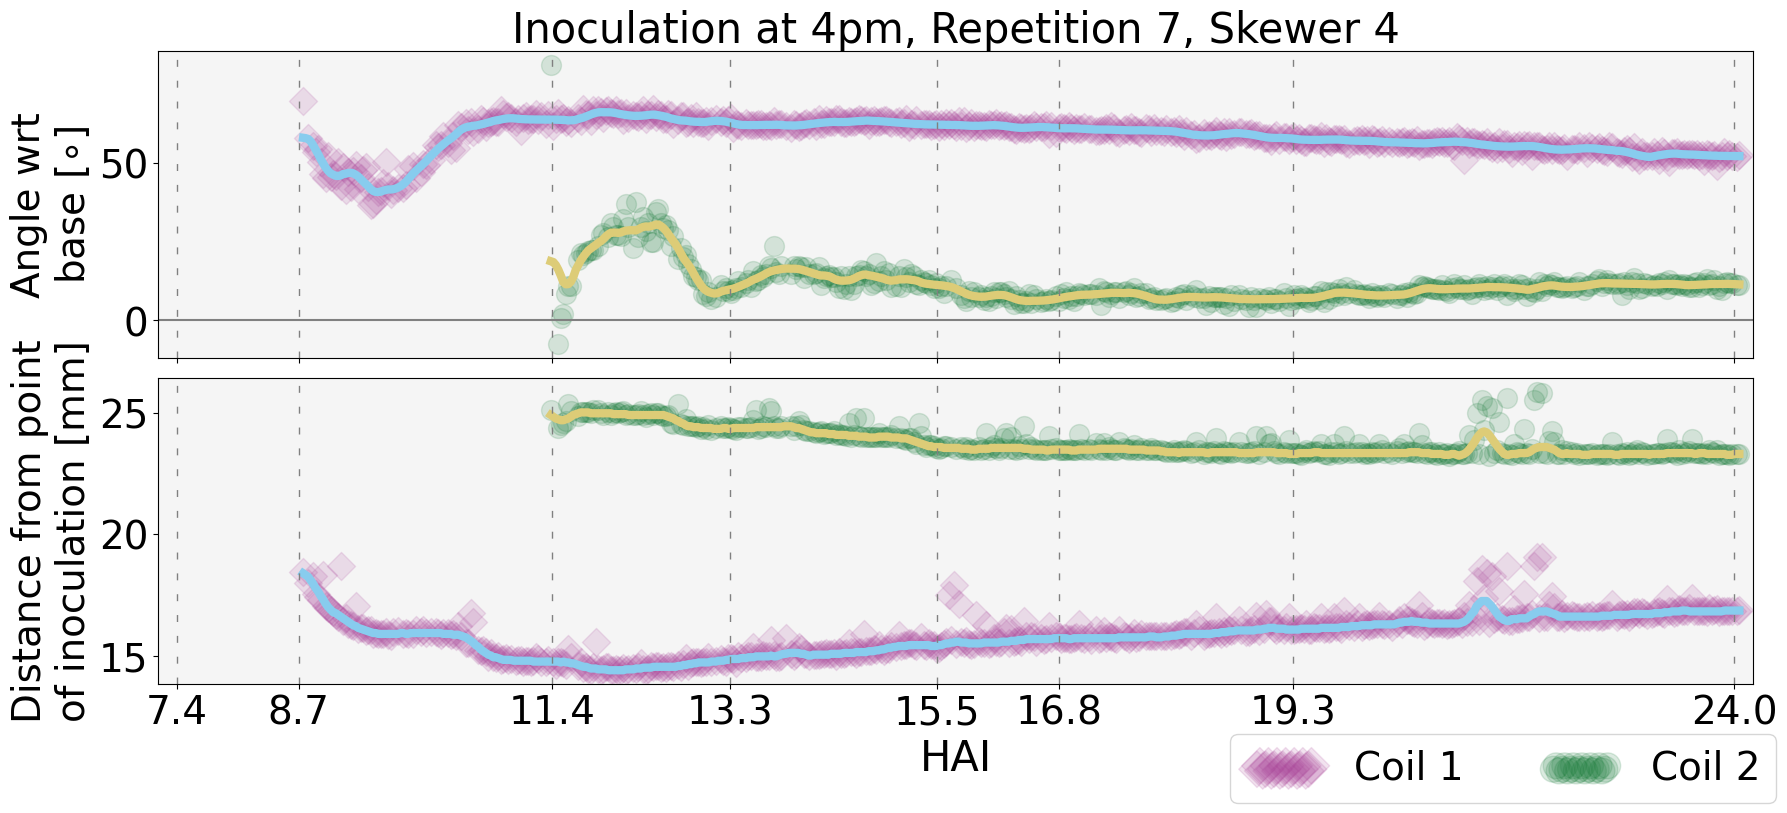

In [498]:
fs,lw,s = 28,6,205
fig, ax = plt.subplots(2,1,figsize=(18,8), sharex=True)
bar = []

for i in range(len(uq)):
    label = 'Coil {}'.format(i+1)
    ax[0].scatter(ang[hdb==uq[i],0]*96/3600, np.rad2deg(ang[hdb==uq[i],1]), s=s, color=colors[i], zorder=1, alpha=0.15, marker=markers[i+1], label=label)
    foo = ax[1].scatter(pos[hdb==uq[i],0]*96/3600, pos[hdb==uq[i],1]/28, s=s, color=colors[i], zorder=1, alpha=0.15, marker=markers[i+1])
    bar.append(foo)
    
    ax[0].plot(mang[i][:,0]*96/3600, np.rad2deg(mang[i][:,1]), lw=lw, color=colors[i+2], zorder=2)
    ax[1].plot(mpos[i][:,0]*96/3600, mpos[i][:,1]/28, lw=lw, color=colors[i+2], zorder=2)

for i in range(len(ax)):
    for j in range(len(idxs)):
        ax[i].axvline(idxs[j], c='gray', ls=(0, (5, 10)) , lw=1)
    ax[i].set_xlim((idxs[0]-.2, idxs[-1]+.2))
    ax[i].set_xticks(idxs, idxs)
    ax[i].tick_params(labelsize=fs)
    ax[i].set_facecolor('whitesmoke')

label = ['Coil {}'.format(j+1) for j in range(2)]
leg = fig.legend(bar, label, fontsize=fs, markerscale=1.3, ncols=2, scatterpoints=20, bbox_to_anchor=(0.5, 0., 0.5, 0.1));

ax[0].set_ylabel('Angle wrt\nbase [$\circ$]', fontsize=fs)
ax[1].set_ylabel('Distance from point\nof inoculation [mm]', fontsize=fs)
ax[0].axhline(0, c='gray')
ax[1].set_xlabel('HAI', fontsize=fs+2)
ax[0].set_title('Inoculation at {}, Repetition {}, Skewer {}'.format(time, rep, pidx+1), fontsize=fs+2)

fig.align_ylabels(ax)
fig.tight_layout()

filename = ssrc + '{}_rep{}/{}_rep{}_plant_{:02d}_posang_ver02'.format(time, rep, time, rep, pidx)
if not os.path.isfile(filename + '.png'):
    plt.savefig(filename + '.png', format='png', bbox_inches='tight', dpi=96)
    plt.savefig(filename + '.svg', format='svg', bbox_inches='tight')
    plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')

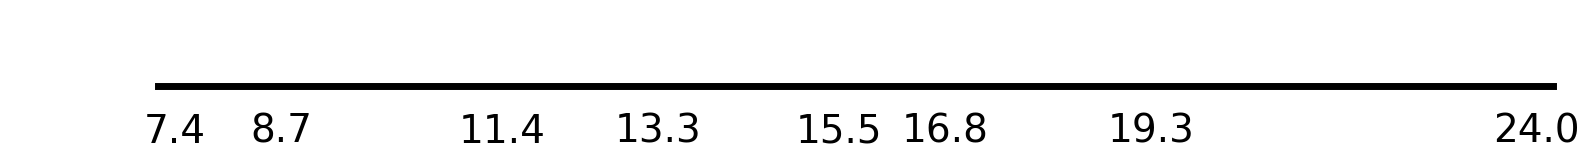

In [499]:
fig, ax = plt.subplots(1,1,figsize=(18,1), sharex=True)
ax = np.atleast_1d(ax).ravel()

for i in range(len(uq)):
    ax[0].scatter(ang[hdb==uq[i],0]*96/3600, np.rad2deg(ang[hdb==uq[i],1]), s=s, color=colors[i], zorder=1, alpha=0, marker=markers[i+1], label=label)
    
for i in range(len(ax)):
    ax[i].set_xlim((idxs[0]-.2, idxs[-1]+.2))
    ax[i].set_xticks(idxs, idxs, fontsize=fs)
    ax[i].tick_params('y', labelsize=fs, color='w', labelcolor='w')
    ax[i].tick_params('x', length=15, width=0)

ax[0].spines[['right', 'top', 'left']].set_visible(False)
ax[0].spines[['bottom']].set_linewidth(5)
ax[0].set_ylabel('Angle wrt\nbase [$\circ$]', fontsize=fs, color='w')

filename = ssrc + '{}_rep{}/{}_rep{}_plant_{:02d}_posang_ver03'.format(time, rep, time, rep, pidx)
if not os.path.isfile(filename + '.png'):
    plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')